In [9]:
import pandas as pd
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

Processing Data for Logistic Regression

In [ ]:
data = pd.read_csv('booking_cleaned(1).csv')
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply the capping function to the remaining variables
data['number of week nights'] = cap_outliers(data['number of week nights'])
data['lead time'] = cap_outliers(data['lead time'])
data['average price'] = cap_outliers(data['average price'])
data['number of children'] = cap_outliers(data['number of children'])

df= data[data['market segment type'].isin(['Online', 'Offline'])]

In [11]:

encoder = OneHotEncoder()
categorical_columns = ['type of meal', 'room type', 'booking status']
numerical_columns = ['number of children', 'number of week nights', 'lead time', 'average price']

#drop useless and target column
drop_columns = ['Booking_ID', 'date of reservation','market segment type']
df_cleaned = df.drop(columns=drop_columns)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])


X = pipeline.fit_transform(df_cleaned)


In [12]:
#Labelencoding to the target
from sklearn.preprocessing import LabelEncoder
y = df['market segment type']
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [13]:
X.dtype

dtype('float64')

In [14]:
y.dtype

dtype('int32')

Model Development

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=43)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=43)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20251, 22), (6751, 22), (20251,), (6751,))

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Setting up the logistic regression classifier
log_reg = LogisticRegression(max_iter=1000, solver='sag',C=1,penalty='l2',random_state=43)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

Model Evaluation

In [17]:
print(classification_report(y_test, log_reg.predict(X_test)))


              precision    recall  f1-score   support

           0       0.75      0.74      0.74      2083
           1       0.89      0.89      0.89      4668

    accuracy                           0.84      6751
   macro avg       0.82      0.82      0.82      6751
weighted avg       0.84      0.84      0.84      6751



In [18]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8426899718560213

In [19]:

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix



array([[1551,  532],
       [ 530, 4138]], dtype=int64)

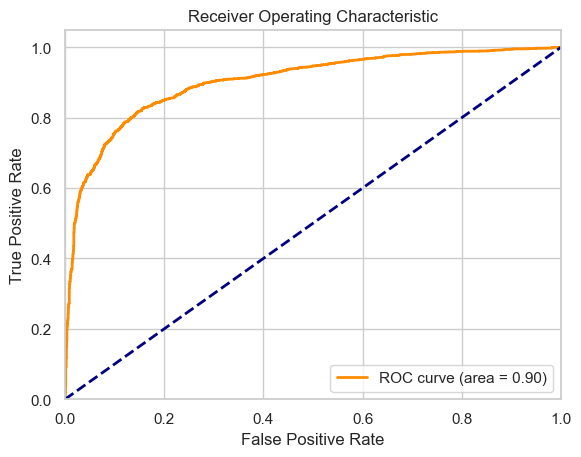

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Model optimization

In [21]:
# Grid search parameters
param_grid = {'solver':['lbfgs','newton-cg','sag','saga'],
    'C': [0.1,1,10],
    'penalty': ['l1','l2']  # Norm used in the penalization
}


# Setting up the grid search
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy')

# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l

({'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}, 0.8456866068734744)

In [22]:
best_model = grid_search.best_estimator_
validation_accuracy = best_model.score(X_val, y_val)
print("Validation Accuracy:", validation_accuracy)
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Validation Accuracy: 0.8429629629629629
Test Accuracy: 0.8425418456524959


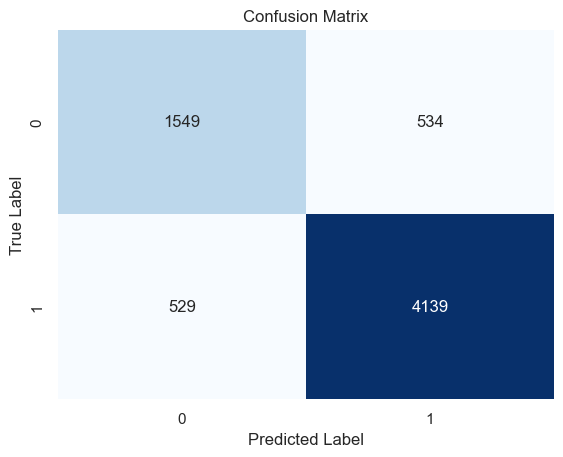

Confusion Matrix:
 [[1549  534]
 [ 529 4139]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.74      2083
           1       0.89      0.89      0.89      4668

    accuracy                           0.84      6751
   macro avg       0.82      0.82      0.82      6751
weighted avg       0.84      0.84      0.84      6751



In [23]:
# Evaluate the model on test data
y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Classification Report:\n", class_report)

In [24]:
data.head(), data.describe()


(  Booking_ID  number of adults  number of children  number of weekend nights  \
 0   INN00001                 1                   0                         2   
 1   INN00002                 1                   0                         1   
 2   INN00003                 2                   0                         1   
 3   INN00004                 1                   0                         0   
 4   INN00005                 1                   0                         1   
 
    number of week nights  type of meal  car parking space    room type  \
 0                      5   Meal Plan 1                  0  Room_Type 1   
 1                      3  Not Selected                  0  Room_Type 1   
 2                      3   Meal Plan 1                  0  Room_Type 1   
 3                      2   Meal Plan 1                  0  Room_Type 1   
 4                      2  Not Selected                  0  Room_Type 1   
 
    lead time market segment type  repeated  average price  

In [25]:
#Potential Outliers:
#Number of Children: The maximum of 10 could be unusual given the mean and standard deviation.
#Number of Week Nights: The maximum of 17 nights is quite high compared to the average.
#Average Price: $540 might be exceptionally high and should be evaluated in the context of typical prices for this data.

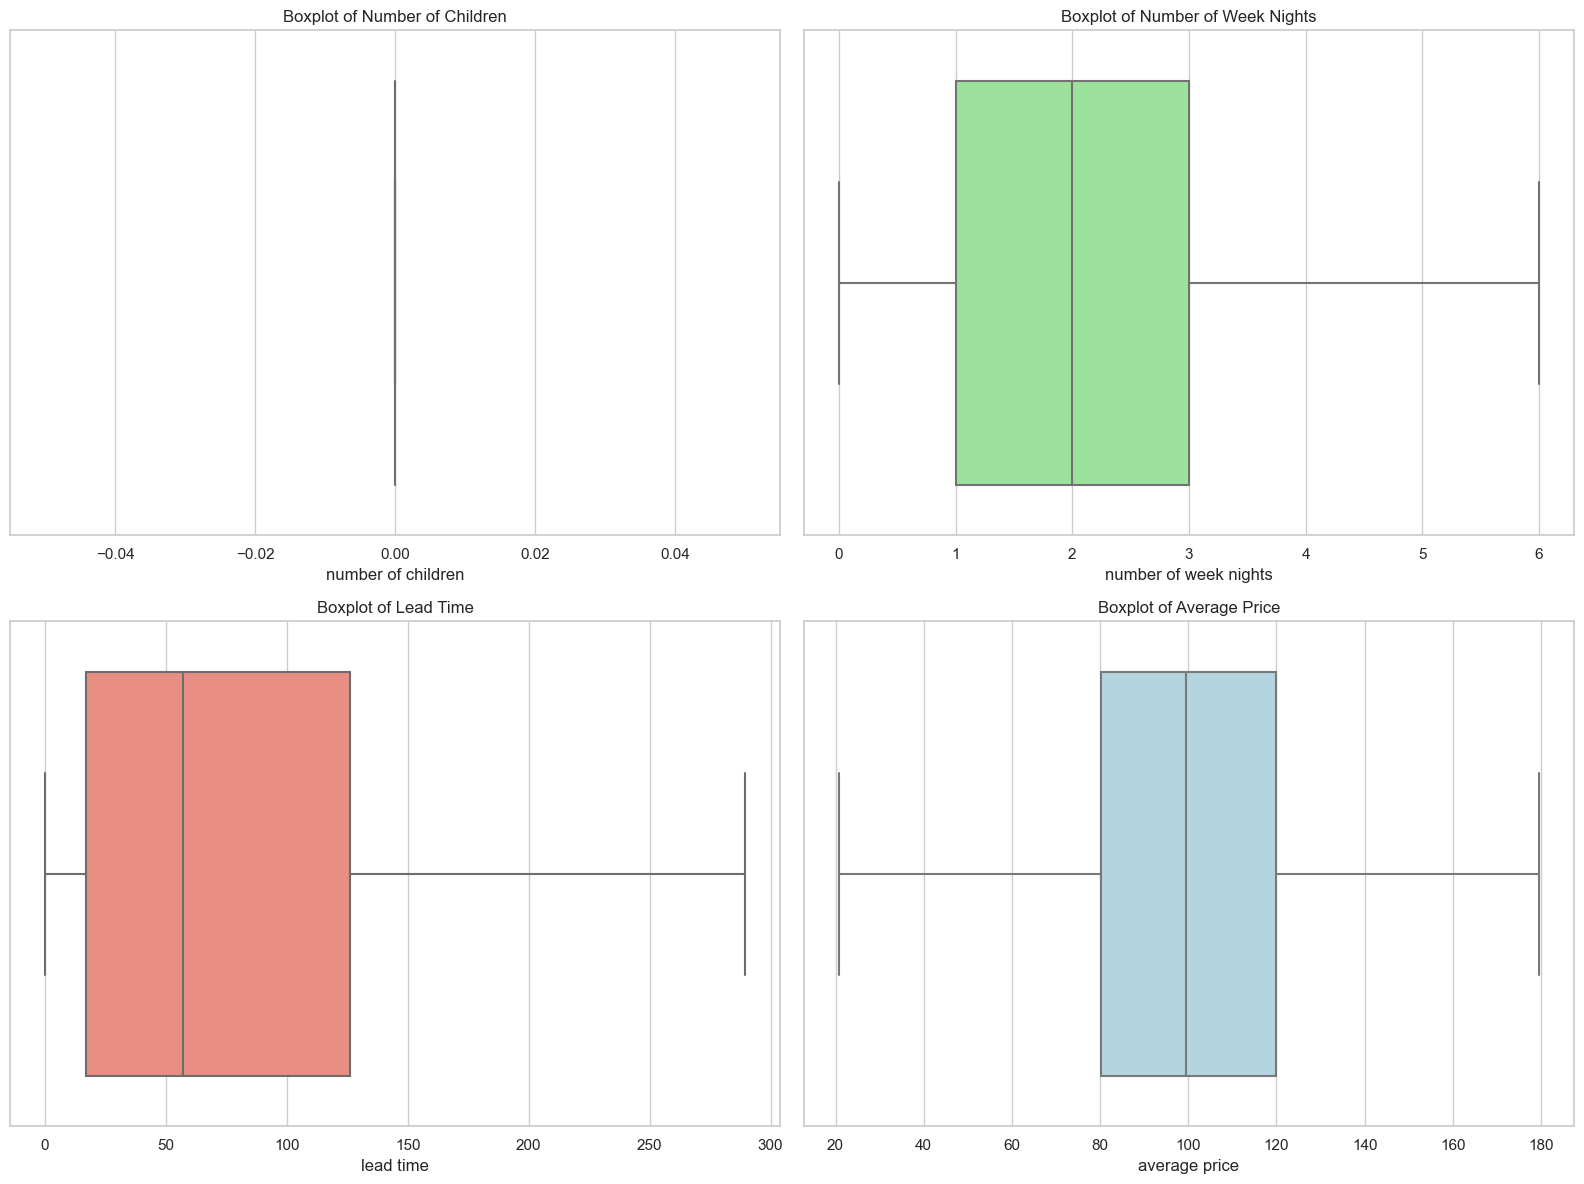

In [26]:
# Notice: The removal of outliers has been applied to the top front for optimization and the increase of the precision score.
# All the optimization will be applied to the final result and be discussed in the report.
# The graph had very clear outliers. But it is not show up here because the optimization codes are applied at the begining.

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Number of children boxplot
sns.boxplot(ax=axes[0, 0], data=data, x='number of children', color='skyblue')
axes[0, 0].set_title('Boxplot of Number of Children')

# Number of week nights boxplot
sns.boxplot(ax=axes[0, 1], data=data, x='number of week nights', color='lightgreen')
axes[0, 1].set_title('Boxplot of Number of Week Nights')

# Lead time boxplot
sns.boxplot(ax=axes[1, 0], data=data, x='lead time', color='salmon')
axes[1, 0].set_title('Boxplot of Lead Time')

# Average price boxplot
sns.boxplot(ax=axes[1, 1], data=data, x='average price', color='lightblue')
axes[1, 1].set_title('Boxplot of Average Price')

plt.tight_layout()
plt.show()


In [27]:
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply the capping function to the remaining variables
data['number of week nights'] = cap_outliers(data['number of week nights'])
data['lead time'] = cap_outliers(data['lead time'])
data['average price'] = cap_outliers(data['average price'])
data['number of children'] = cap_outliers(data['number of children'])
